In [11]:
import evaluate
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from groq import Groq, RateLimitError

In [12]:
preferences_df = pd.read_csv("preprocessed_data.csv", index_col=0)
print(preferences_df.shape)
print(preferences_df.dropna().shape)

(14981, 3)
(14973, 3)


In [13]:
TEST_SIZE = 0.2
eval_df = preferences_df.sample(frac=TEST_SIZE, random_state=0)
train_df = preferences_df[~preferences_df.index.isin(eval_df.index)].sample(frac=1.0)

In [14]:
print(eval_df.shape)
eval_df.head()

(2996, 3)


,question,answer,incorrect_answer
13212,What is (are) ataxia with oculomotor apraxia ?,Ataxia with oculomotor apraxia is a condition ...,Ataxia with oculomotor apraxia (AOA) is a sing...
4942,What are the symptoms of Anencephaly ?,What are the signs and symptoms of Anencephaly...,Anencephaly primarily presents with symptoms r...
3730,What are the genetic changes related to D-bifu...,D-bifunctional protein deficiency is caused by...,Genetic changes in D-bifunctional protein defi...
5979,What are the symptoms of Hypersensitivity Pneu...,Signs and symptoms of hypersensitivity pneumon...,Hypersensitivity Pneumonitis symptoms vary dep...
9743,What causes Brittle diabetes ?,What causes brittle diabetes? There are multip...,Brittle diabetes is primarily caused by a gene...


In [5]:
GROQ_API_KEY = os.environ["GROQ_API_KEY"]
client = Groq(api_key=GROQ_API_KEY)

In [6]:
eval_complete_df = eval_df.copy()
eval_complete_df["base_model_answer"] = None

In [7]:
for idx, question in eval_complete_df[
    eval_complete_df.base_model_answer.isna()
].question.items():
    try:
        groq_response = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": question,
                }
            ],
            model="llama3-8b-8192",
            temperature=0,
        )
        eval_complete_df.loc[idx, "base_model_answer"] = groq_response.choices[
            0
        ].message.content
        # print(idx)
    except RateLimitError as e:
        print(e)
        break

Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01jf03y460eaytqmjbmbyx4cvx` on : Limit 500000, Used 500615, Requested 18. Please try again in 1m49.386999999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}


In [9]:
eval_complete_df.base_model_answer.notna().value_counts()

base_model_answer
False    1921
True     1075
Name: count, dtype: int64

In [10]:
eval_complete_df.to_parquet("base_model_answers_eval.parquet.gz")

In [11]:
finetuned_model_responses = json.load(open("partial_eval_results.json"))
finetuned_model_df = pd.DataFrame(finetuned_model_responses)
finetuned_model_df.head()

,question,model_answer
0,What is (are) ataxia with oculomotor apraxia ?,What is (are) ataxia with oculomotor apraxia ?...
1,What are the symptoms of Anencephaly ?,What are the symptoms of Anencephaly ? The sym...
2,What are the genetic changes related to D-bifu...,What are the genetic changes related to D-bifu...
3,What are the symptoms of Hypersensitivity Pneu...,What are the symptoms of Hypersensitivity Pneu...
4,What causes Brittle diabetes ?,What causes Brittle diabetes ? Brittle diabete...


In [12]:
eval_complete_df = eval_complete_df.iloc[: len(finetuned_model_df)].copy()

In [13]:
eval_complete_df["finetuned_question"] = finetuned_model_df.question.values
eval_complete_df["finetuned_model_answer"] = finetuned_model_df.model_answer.values

### Sanity check

Check if series are aligned: evaluation dataset question and finetuned model dataset questions should match

In [14]:
pd.testing.assert_series_equal(
    eval_complete_df.question, eval_complete_df.finetuned_question, check_names=False
)

### Drop samples with no base model answers

In [18]:
eval_complete_df = eval_complete_df.loc[eval_complete_df.base_model_answer.notna()]
print(eval_complete_df.shape)

(1075, 6)


# Evaluate BLEU and ROUGE metrics

Let's start with the simplest set of metrics, based on comparing ngrams of the expected answer and the model response

In [19]:
bleu_evaluator = evaluate.load("bleu")

In [20]:
base_model_bleu = bleu_evaluator.compute(
    predictions=eval_complete_df.base_model_answer.values,
    references=eval_complete_df.answer.values,
)
print(base_model_bleu)

{'bleu': 0.039157648674871835, 'precisions': [0.24448238776335626, 0.0588996883041488, 0.01980360367850495, 0.008244448714713366], 'brevity_penalty': 1.0, 'length_ratio': 1.6129225956388464, 'translation_length': 435152, 'reference_length': 269791}


In [21]:
final_model_bleu = bleu_evaluator.compute(
    predictions=eval_complete_df.finetuned_model_answer.values,
    references=eval_complete_df.answer.values,
)
print(final_model_bleu)

{'bleu': 0.07984662735726453, 'precisions': [0.44545726737416413, 0.1864897466827503, 0.12229234871241014, 0.09623988576868157], 'brevity_penalty': 0.45154675808133105, 'length_ratio': 0.5570793688447724, 'translation_length': 150295, 'reference_length': 269791}


In [46]:
bleu_compare = pd.Series(
    {
        "Llama3 8B (base model)": base_model_bleu["bleu"],
        "Fine tuned model": final_model_bleu["bleu"],
    }
)
bleu_compare["Improvement"] = (bleu_compare.pct_change()).map("{:.2%}".format).iloc[1]
bleu_compare

Llama3 8B (base model)    0.039158
Fine tuned model          0.079847
Improvement                103.91%
dtype: object

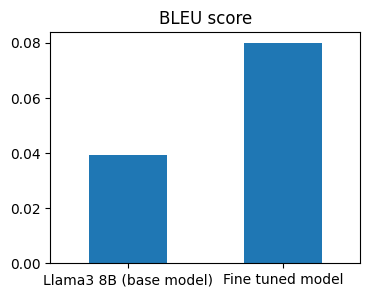

In [47]:
ax = bleu_compare.iloc[:2].plot.bar(figsize=(4, 3))
ax.set_title("BLEU score")
_ = plt.xticks(rotation=0)

In [23]:
rouge_evaluator = evaluate.load("rouge")

In [24]:
base_model_rouge = rouge_evaluator.compute(
    predictions=eval_complete_df.base_model_answer.values,
    references=eval_complete_df.answer.values,
)
print(base_model_rouge)

{'rouge1': 0.2920768173035096, 'rouge2': 0.07439805413646888, 'rougeL': 0.15455779600466904, 'rougeLsum': 0.21825463762500416}


In [25]:
final_model_rouge = rouge_evaluator.compute(
    predictions=eval_complete_df.finetuned_model_answer.values,
    references=eval_complete_df.answer.values,
)
print(final_model_rouge)

{'rouge1': 0.336616829876394, 'rouge2': 0.1509000042342874, 'rougeL': 0.22936154993456587, 'rougeLsum': 0.25913932692223796}


In [26]:
rouge_compare_df = pd.DataFrame(
    [base_model_rouge, final_model_rouge],
    index=["Llama3 8B (base model)", "Fine tuned model"],
)
rouge_compare_df

,rouge1,rouge2,rougeL,rougeLsum
Llama3 8B (base model),0.292077,0.074398,0.154558,0.218255
Fine tuned model,0.336617,0.150900,0.229362,0.259139


### Rouge metrics description

ROUGE-N - Measures the overlap of n-grams between the system and the reference summaries. For example, ROUGE-1 refers to the overlap of unigrams (each word), while ROUGE-2 refers to the overlap of bigrams (two consecutive words).  
  
ROUGE-L - Based on the length of the Longest Common Subsequence (LCS). Calculates the weighted harmonic mean (or f-measure) by combining the precision score and the recall score.  
*sentence-level*: Compute longest common subsequence (LCS) between two pieces of text. Newlines are ignored.  
*summary-level*: Newlines in the text are interpreted as sentence boundaries, and the LCS is computed between each pair of reference and candidate sentences. This is the ROUGE-L reported in the original paper.  


In [32]:
rouge_compare_df = rouge_compare_df.rename(
    columns={
        "rouge1": "ROUGE-1",
        "rouge2": "ROUGE-2",
        "rougeL": "ROUGE-L sentence-level",
        "rougeLsum": "ROUTE-L summary-level",
    }
)
rouge_compare_df.round(3).style.background_gradient(axis=None)

,ROUGE-1,ROUGE-2,ROUGE-L sentence-level,ROUTE-L summary-level
Llama3 8B (base model),0.292000,0.074000,0.155000,0.218000
Fine tuned model,0.337000,0.151000,0.229000,0.259000


In [39]:
rouge_compare_df.T.assign(
    Improvement=(rouge_compare_df.pct_change()).map("{:.2%}".format).iloc[1]
)

,Llama3 8B (base model),Fine tuned model,Improvement
ROUGE-1,0.292077,0.336617,15.25%
ROUGE-2,0.074398,0.150900,102.83%
ROUGE-L sentence-level,0.154558,0.229362,48.40%
ROUTE-L summary-level,0.218255,0.259139,18.73%


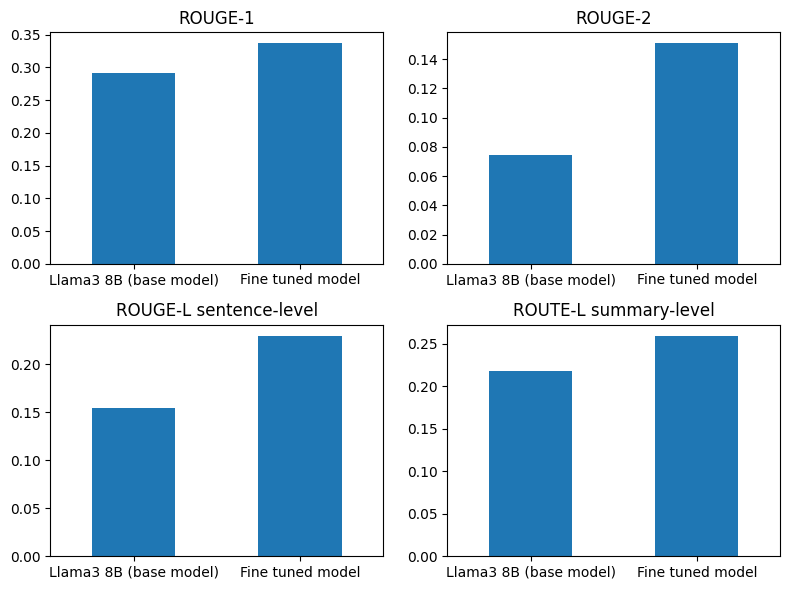

In [28]:
fig, ax_all = plt.subplots(2, 2, figsize=(8, 6))

for col, ax in zip(rouge_compare_df.columns, ax_all.flatten()):
    rouge_compare_df[col].plot.bar(ax=ax)
    ax.set_title(col)
    ax.tick_params(axis="x", rotation=0)
fig.tight_layout()

In [49]:
eval_complete_df.to_parquet("eval_complete_df.parquet.gz")
loaded = pd.read_parquet("eval_complete_df.parquet.gz")
pd.testing.assert_frame_equal(eval_complete_df, loaded)

In [6]:
eval_complete_df = pd.read_parquet("eval_complete_df.parquet.gz")

# Sentence Transformers (SBERT) similarity evaluation

In this more advanced evaluation, we will use a Sentence Transformers model to encode the correct answer, the base model's response, and the fine-tuned model's response, and then compare the similarity between the correct answer and each model's response.

In [ ]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import numpy as np

similarity_model = SentenceTransformer("stsb-roberta-large")


# Compute semantic similarity
base_scores = [
    util.pytorch_cos_sim(similarity_model.encode(ref), similarity_model.encode(resp))[
        0
    ][0].item()
    for ref, resp in zip(
        eval_complete_df.answer.values, eval_complete_df.base_model_answer.values
    )
]
fine_tuned_scores = [
    util.pytorch_cos_sim(similarity_model.encode(ref), similarity_model.encode(resp))[
        0
    ][0].item()
    for ref, resp in zip(
        eval_complete_df.answer.values, eval_complete_df.finetuned_model_answer.values
    )
]

### Compare average similarity score

In [8]:
sbert_compare = pd.Series(
    {
        "Llama3 8B (base model)": np.mean(base_scores),
        "Fine tuned model": np.mean(fine_tuned_scores),
    }
)
sbert_compare["Improvement"] = (sbert_compare.pct_change()).map("{:.2%}".format).iloc[1]
sbert_compare

Llama3 8B (base model)    0.624496
Fine tuned model          0.632165
Improvement                  1.23%
dtype: object

### Compare median similarity score

In [16]:
sbert_compare_median = pd.Series(
    {
        "Llama3 8B (base model)": np.median(base_scores),
        "Fine tuned model": np.median(fine_tuned_scores),
    }
)
sbert_compare_median["Improvement"] = (
    (sbert_compare_median.pct_change()).map("{:.2%}".format).iloc[1]
)
sbert_compare_median

Llama3 8B (base model)    0.624317
Fine tuned model          0.648657
Improvement                  3.90%
dtype: object

<Axes: >

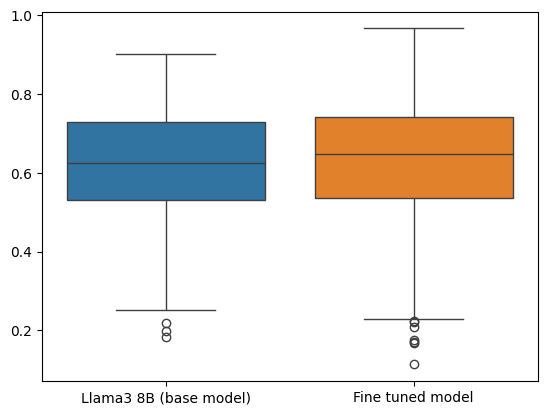

In [10]:
sns.boxplot(
    pd.DataFrame(
        {
            "Llama3 8B (base model)": base_scores,
            "Fine tuned model": fine_tuned_scores,
        }
    )
)

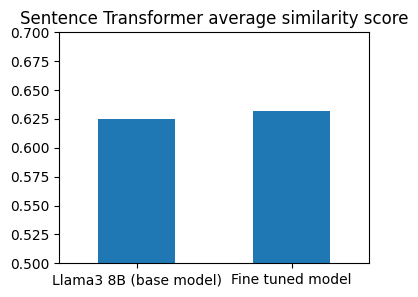

In [25]:
ax = sbert_compare.iloc[:2].plot.bar(figsize=(4, 3))
ax.set_title("Sentence Transformer average similarity score")
ax.set_ylim((0.5, 0.7))
_ = plt.xticks(rotation=0)

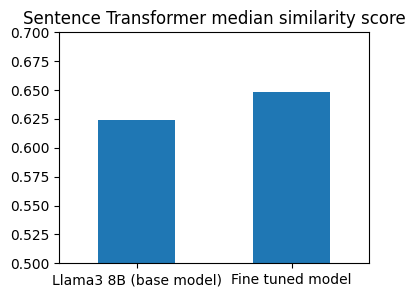

In [26]:
ax = sbert_compare_median.iloc[:2].plot.bar(figsize=(4, 3))
ax.set_title("Sentence Transformer median similarity score")
ax.set_ylim((0.5, 0.7))
_ = plt.xticks(rotation=0)

In [36]:
sim_scores = pd.DataFrame(
    {
        "base": base_scores,
        "finetune": fine_tuned_scores,
    }
)
sample_sim_scores = (
    sim_scores.assign(diff=sim_scores.finetune - sim_scores.base)
    .sort_values("diff", ascending=False)
    .sample(5, random_state=0)
)
sample_sim_scores

,base,finetune,diff
522,0.670254,0.774847,0.104593
393,0.576144,0.551199,-0.024945
201,0.612073,0.558032,-0.054042
203,0.575629,0.597081,0.021451
631,0.592271,0.589947,-0.002324


In [59]:
top_performance = (
    sim_scores.assign(diff=sim_scores.finetune - sim_scores.base)
    .sort_values("diff", ascending=False)
    .head(4)
)
top_performance

,base,finetune,diff
189,0.410467,0.920789,0.510323
913,0.326739,0.828728,0.501989
803,0.392343,0.861721,0.469378
626,0.372567,0.838672,0.466105


In [46]:
def print_sample(row):
    print(f"QUESTION\n{'-' * 30}\n{row.question}\n\n")
    print(f"CORRECT ANSWER\n{'-' * 30}\n{row.answer}\n\n")
    print(f"BASE MODEL RESPONSE\n{'-' * 30}\n{row.base_model_answer}\n\n")
    print(f"FINE TUNED MODEL RESPONSE\n{'-' * 30}\n{row.finetuned_model_answer}\n\n")

In [64]:
print_sample(eval_complete_df.iloc[522])

QUESTION
------------------------------
What is (are) Rheumatic Fever ?


CORRECT ANSWER
------------------------------
Rheumatic fever is an inflammatory condition that may develop after infection with group A Streptococcus bacteria, such as strep throat or scarlet fever. It is primarily diagnosed in children between the ages of 6 and 16 and can affect the heart, joints, nervous system and/or skin. Early signs and symptoms include sore throat; swollen red tonsils; fever; headache; and/or muscle and joint aches. Some affected people develop rheumatic heart disease, which can lead to serious inflammation and scarring of the heart valves. It is not clear why some people who are infected with group A Streptococcus bacteria go on to develop rheumatic fever, while others do not; however, it appears that some families may have a genetic susceptibility to develop the condition. Treatment usually includes antibiotics and/or anti-inflammatory medications.
Disclaimer: This information is for edu